In [1]:
#meta 1/5/2024 NLP for UDS demo. Part 2 Model
# Text Analytics. Trends and topic modeling for UDS
#      Data: How did you...
      
#      input: myData/howdidu_tidy.csv
#      output: myVis/*

#based on 1_topic_modeling.ipynb or Employee Survey 2020 (pickle with sample dataset, 2018/2019 survey results, in English only)
#meta 10/14/2020 myTopicModeling for Employee Survey 2020
#prev in 1_topic_modeling.ipynb
#10/14/2020 TOPIC MODELING - WITH TF-IDF
#      Summary of improving the extraction of words in bow
#      2 Candidate examples: 10 topics with ngram(1,3) and 2 topics with ngram(2,3)
#10/15/2020 TOPIC MODELING - LDA VIS
#      Interactive topic model visualization
#      Results with `q_better` only
#      Src https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0


#history
#1/3/2024 NLP: WORDCLOUD & TOPIC MODELING

#1/5/2024 NLP: 1ST DRAFT CLUSTERING

#2/10/2004 META: MOVE TO MAC
#      local: get csv from ~2023-12-31


#Pipeline: nlp_0_data -> nlp_1_dataprep -> nlp_2_model (here)

#$config $learn


In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from joblib import load, dump
#import csv

In [3]:
#modeling
from sklearn.feature_extraction.text import CountVectorizer #transformer to tokenize dataset, aka bag-of-words activity
from sklearn.feature_extraction.text import TfidfVectorizer #rescale features by how informative they are

from sklearn.decomposition import LatentDirichletAllocation

# Import vis
from wordcloud import WordCloud
import plotly.express as px

In [4]:
print(sys.version)
np.__version__, pd.__version__

3.10.10 (main, Jan 17 2024, 01:36:04) [Clang 12.0.5 (clang-1205.0.22.11)]


('1.26.3', '2.1.4')

Global vars and functions

In [5]:
#data
DATA_DIR = 'myData'
DATA_FILE_IN = DATA_DIR + '/howdidu_tidy.csv' #$config

In [6]:
def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<19}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<16}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<25}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

# NLP: Text Analytics 
- Trends  
- Topic Modeling  

## 0. Load Data

In [7]:
df_tidy = pd.read_csv(DATA_FILE_IN)

print(df_tidy.shape)
print(df_tidy.columns)
df_tidy.head();

(326, 7)
Index(['Unnamed: 0', 'LGL Constituent ID', 'First Name', 'Last Name',
       'Contact rpt. description', 'Contact rpt. type',
       'contact_report_desc_short'],
      dtype='object')


## 2. Prep Data for ML
- Feature engineering  
concatentate text columns

`Contact rpt. description` used for X

In [8]:
df_tidy['all_text'] = df_tidy['Contact rpt. description']

print(df_tidy.shape)
df_tidy.head();

(326, 8)


In [9]:
df_tidy.columns

Index(['Unnamed: 0', 'LGL Constituent ID', 'First Name', 'Last Name',
       'Contact rpt. description', 'Contact rpt. type',
       'contact_report_desc_short', 'all_text'],
      dtype='object')

## 1. Process data
Prepare for Text Analytics 

### 1.1. Prep Data for ML  
Assemble Data into ML Expected Format.  Scikit-learn expects a Numpy array-like structure. Transform the tidy dataset to a structure acceptable by algorithm: 
input features X(matrix) and target variable y(vector). 

X - column 'all_text'  
y - n/a

#### Create X input

In [10]:
#interested in words in all rows, column 0
#text_train = df_tidy[['Q_COMMENT_BETTER','Q_AGREE_SATISFIED']].iloc[:,0]
text_train = df_tidy['all_text'] #.iloc[:,0]
text_train.shape

(326,)

### 1.2 EDA with WordCloud
src https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [11]:
# Join the different processed titles together.
#long_string = ','.join(list(papers['paper_text_processed'].values))
long_string = ','.join(list(text_train))
len(long_string)

25669

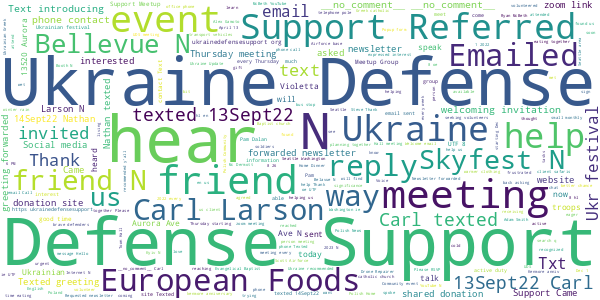

In [12]:
# Create a WordCloud object
wordcloud_base = WordCloud(background_color="white", max_words=5000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_base.generate(long_string)
# Visualize the word cloud
wordcloud_base.to_image()

## 2. Baseline Model

#### Baseline Bag-of-Words
- Tokenize dataset and build the vocablulary  
- Vocabulary and features  
- Create bow representation of training data - SciPy sparse matrix
- dtm "dense" NumPy array to look actual content

In [13]:
#tokenize train data and build the vocabulary
vect_base = CountVectorizer().fit(text_train)

# `transform` converts text to a bow representation: SciPy sparse matrix only stores non-zero entries
X_base = vect_base.transform(text_train)
print("X_base:\n{}".format(repr(X_base)))

# dense dtm
#dtm_base = X_base.to_array()
#print ("document-term dimensions:", dtm_base.shape)


X_base:
<326x1004 sparse matrix of type '<class 'numpy.int64'>'
	with 3385 stored elements in Compressed Sparse Row format>


In [14]:
# vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vect_base.vocabulary_)))
#print("Vocab (with word indices): {}".format(vect_base.vocabulary_))

#get features
feature_names_base = vect_base.get_feature_names_out() #ordered alphabetically
#preview features
print("Number of features: {}".format(len(feature_names_base)))
print("First 20 features:\n{}".format(feature_names_base[:20]))
print("Features 2010 to 2030:\n{}".format(feature_names_base[2010:2030]))
print("Every 500th feature:\n{}".format(feature_names_base[::500]))

Vocab size: 1004
Number of features: 1004
First 20 features:
['10' '100' '11' '12345' '12532050468' '13' '13520' '13sept22' '14'
 '14sept22' '16' '20' '2022' '2023' '23' '25' '26' '300' '33' '365']
Features 2010 to 2030:
[]
Every 500th feature:
['10' 'list' 'youtube']


Note: many uninformative features (like the numbers)

#### Topic Modeling and Document Clustering
Assigning documents to one or multiple topis, usually without supervision.  

If each document can have more than one topic, the task relate to the decomposition methods (PCA, NMF and t-SNE). Each of the components we learn then corresponds to one topic, and the coefficients in the representation of a document tell us how strongly related that document is to a particular topic.

Decomposition algo: Latent Dirichlet Allocation
the LDA model tries to find groups of words (the topics) that appear together frequently.  It requires that each doc can be understood as a "mixture" of a subset of the topics.  A topic may not result in a semantic meaning - groups of words appearing together not as expected by a human.

In [15]:
lda_base = LatentDirichletAllocation(n_components=10, learning_method="batch", max_iter=25, random_state=0)
# Build the model and transform the data in one step
# Computing transform takes some time, and we can save time by doing both at once
document_topics_base = lda_base.fit(X_base)

print("lda_base.components_.shape: {}".format(lda_base.components_.shape))

lda_base.components_.shape: (10, 1004)


In [16]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_base = np.argsort(lda_base.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
#np.array(feature_names_base)

In [17]:
# Print out the 10 topics:
print_topics(topics=range(10), feature_names=np.array(feature_names_base), sorting=sorting_base, topics_per_chunk=5, n_words=10)

topic 0                  topic 1                  topic 2                  topic 3                  topic 4                  
--------                 --------                 --------                 --------                 --------                 
poster                   and                      to                       to                       to                       
of                       to                       email                    the                      and                      
he                       he                       in                       and                      pam                      
the                      texted                   festival                 in                       social                   
at                       have                     bellevue                 you                      of                       
in                       txt                      reply                    with                     in                

Not meaningful so far. Expected with uninformative features.

##### Visualize Baseline with WordCloud
Note:  using the built-in STOPWORDS list

In [18]:
# Join tokens together.
#long_string = ','.join(list(text_train))
long_string = ','.join(vect_base.vocabulary_)
len(long_string)

7092

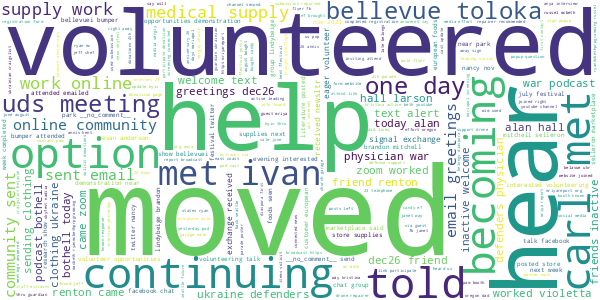

In [19]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

Some words shouldn't make it here, i.e. `within`, `re`

Examine data closer:

In [20]:
# vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vect_base.vocabulary_)))
#print("Vocab (with word indices): {}".format(vect_base.vocabulary_))

#preview features
feature_names_base = vect_base.get_feature_names_out() #ordered alphabetically
print("Number of features: {}".format(len(feature_names_base)))
print("First 20 features:\n{}".format(feature_names_base[:20]))
print("Features 510 to 530:\n{}".format(feature_names_base[510:530]))
print("Every 100th feature:\n{}".format(feature_names_base[::100]))

Vocab size: 1004
Number of features: 1004
First 20 features:
['10' '100' '11' '12345' '12532050468' '13' '13520' '13sept22' '14'
 '14sept22' '16' '20' '2022' '2023' '23' '25' '26' '300' '33' '365']
Features 510 to 530:
['love' 'loyal' 'macbeth' 'madden' 'made' 'mail' 'mailed' 'main' 'make'
 'makor' 'man' 'manner' 'many' 'march' 'marching' 'marcy' 'mariupol'
 'market' 'marketplace' 'marlon']
Every 100th feature:
['10' 'attendance' 'come' 'events' 'hosting' 'list' 'of' 'raiser' 'so'
 'trips' 'youtube']


In [21]:
#save vocab base 
'''csv_columns = ['word','idx']
csv_file = "myExplore/vocab_base_index.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_base.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_base.vocabulary_[key]))
except IOError:
    print("I/O error")
'''

'csv_columns = [\'word\',\'idx\']\ncsv_file = "myExplore/vocab_base_index.csv"\ntry:\n    with open(csv_file, \'w\') as f:\n        for key in vect_base.vocabulary_.keys():\n            f.write("%s,%s\n"%(key,vect_base.vocabulary_[key]))\nexcept IOError:\n    print("I/O error")\n'

## 3. Improve the Extraction of Words
- `min_df` Cut back on features that appear in less than min # of docs. Don't use tokens that appear in only n_min document(s).  
Loses most numbers: While most numbers don't have semantic meaning, some may, for example 401k.

- `max-df` to discard words that appear too frequently.

- `stopwords` discard a predefined list of meaningless words

- `n-grams` bi-grams and tri-grams can help with interpretability

##### Weeding out the meaningful from the not meaningful "words" can be tricky.

Should be less obscure words or misspellings.  
Fewer features help with speed and made the topics more interpretable (with throwing away useless features).  

- `tf-idf` Rescaling the Data with tf-idf
\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \log\big(\frac{N + 1}{N_w + 1}\big) + 1
\end{equation*}

Low tf-idf features means either used very commonly across documents or only used sparingly (and only in very long documents, which n/a here).

High tf-idf appear frequently in a document but not in very many documents -> descriptive of that document.

Low idf - appear frequently and therefore deemed less important.  But are they?  Seems everybody's bringing up same points.  Use your judgement when interpreting algorithms.



## 4. Preview Candidates: Topic Modeling and Document Clustering
Algo: Latent Dirichlet Allocation  
### 4.1 Candidate 1 - 10 topics and ngrams (1,3)

In [22]:
from sklearn.feature_extraction import text

In [23]:
my_stop_words_custom = ['ukraine defense', 'defense support', 'did']
my_stop_words = list(text.ENGLISH_STOP_WORDS.union(my_stop_words_custom))

In [24]:
#original
#vect = CountVectorizer(max_features=10000, ngram_range=(2, 3), stop_words="english", max_df=.15)

#tokenize train data and build the vocabulary
vect_c1 = TfidfVectorizer(min_df = .01, ngram_range=(1, 3), stop_words=my_stop_words) #"english") #, max_df=.99, norm=None)

# `transform` converts text to a bow representation: SciPy sparse matrix only stores non-zero entries
X_c1 = vect_c1.fit_transform(text_train)

/Users/amigopro/anyaconda3/myGitrepo/my-razom/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['defense', 'support', 'ukraine'] not in stop_words.
  warnings.warn(


In [25]:
# vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vect_c1.vocabulary_)))
#print("Vocab (with word indices): {}".format(vect_c1.vocabulary_))

# get the feature names from the vectorizer
#feature_names_c1 = vect_c1.get_feature_names() #ordered alphabetically
feature_names_c1 = np.array(vect_c1.get_feature_names_out())
print("Number of features: {}".format(len(feature_names_c1)))
print("First 20 features:\n{}".format(feature_names_c1[:20]))

Vocab size: 189
Number of features: 189
First 20 features:
['13520' '13520 aurora' '13520 aurora ave' '13sept22' '13sept22 carl'
 '13sept22 carl texted' '14sept22' '14sept22 nathan'
 '14sept22 nathan texted' '2023' '__no_comment__' 'active' 'april' 'asked'
 'attended' 'aurora' 'aurora ave' 'ave' 'bellevue' 'came']


In [26]:
#save vocab c1 
'''csv_columns = ['word','idx']
csv_file = "myExplore/vocab_base_index_tfidif_min01_max99.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_c1.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_c1.vocabulary_[key]))
except IOError:
    print("I/O error")'''


'csv_columns = [\'word\',\'idx\']\ncsv_file = "myExplore/vocab_base_index_tfidif_min01_max99.csv"\ntry:\n    with open(csv_file, \'w\') as f:\n        for key in vect_c1.vocabulary_.keys():\n            f.write("%s,%s\n"%(key,vect_c1.vocabulary_[key]))\nexcept IOError:\n    print("I/O error")'

In [27]:
# find maximum value for each of the features over dataset:
max_value = X_c1.max(axis=0).toarray().ravel()
print("Max value shape:", max_value.shape)

sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(feature_names_c1[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(feature_names_c1[sorted_by_tfidf[-20:]]))

sorted_by_idf = np.argsort(vect_c1.idf_)
print("Features with lowest idf:\n{}".format(feature_names_c1[sorted_by_idf[:20]]))

Max value shape: (189,)
Features with lowest tfidf:
['13520' '13520 aurora' 'ukrainedefensesupport org' '13520 aurora ave'
 'ave' 'aurora ave' 'aurora' 'support way hear' 'way hear' 'support way'
 'defense support way' 'way hear ukraine' 'event hear ukraine'
 'event hear' 'support event hear' 'meetup group' 'support meetup'
 'support meetup group' 'defense support meetup' 'defense support ukraine']
Features with highest tfidf: 
['kenmore' 'kent' 'talk' 'instagram' 'meeting' 'meetup' 'facebook'
 'festival' 'twitter' 'txt' 'email' 'emailed' 'ukraine' 'ukrainian' 'carl'
 'pam' 'poster' 'skyfest' 'near' 'news']
Features with lowest idf:
['ukraine' 'support' 'defense' 'ukraine defense support' 'ukraine defense'
 'defense support' 'hear' 'hear ukraine' 'hear ukraine defense' 'meeting'
 'friend' 'texted' 'event' 'carl' '__no_comment__' 'email'
 'defense support referred' 'text' 'referred friend'
 'defense support event']


##### Model 10 topics

In [28]:
n_topics_c1 = 10

lda_c1 = LatentDirichletAllocation(n_components=n_topics_c1, learning_method="batch", max_iter=25, random_state=0)
# Build the model and transform the data in one step
# Computing transform takes some time and we can save time by doing both at once
document_topics_c1 = lda_c1.fit_transform(X_c1)

print("lda_c1.components_.shape: {}".format(lda_c1.components_.shape))

lda_c1.components_.shape: (10, 189)


In [29]:
n_topics_c1 = 10

lda_c1 = LatentDirichletAllocation(n_components=n_topics_c1, learning_method="batch", max_iter=25, random_state=0)
# Build the model and transform the data in one step
# Computing transform takes some time and we can save time by doing both at once
document_topics_c1 = lda_c1.fit_transform(X_c1)

print("lda_c1.components_.shape: {}".format(lda_c1.components_.shape))

lda_c1.components_.shape: (10, 189)


In [30]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_c1 = np.argsort(lda_c1.components_, axis=1)[:, ::-1]


In [31]:
# Print out the n topics:
print_topics(topics=range(n_topics_c1), feature_names=feature_names_c1,
                           sorting=sorting_c1, topics_per_chunk=4, n_words=10)

topic 0                  topic 1                  topic 2                  topic 3                  
--------                 --------                 --------                 --------                 
__no_comment__           festival                 ukraine                  flyer                    
ukrainian                met                      defense support          emailed                  
reply                    bellevue                 ukraine defense support  facebook                 
reply email              festival bellevue        ukraine defense          instagram                
email                    news                     support                  newsletter               
polish                   13sept22                 defense                  group                    
nathan texted            carl texted              hear                     said                     
14sept22                 13sept22 carl            hear ukraine defense     kent            

Topics may be specific or not specific enough, many are hard to interpret.  

Examine one topic.  
Confirm the intuition gained from looking at the highest-ranking words per topic by looking at the documents that are assigned to this topic. 

What kinds of comments are assigned to this topic? 

In [32]:
# sort by weight of "balance" topic 0
topic_c1  = np.argsort(document_topics_c1[:, 0])[::-1]
print(topic_c1.shape)

# print the five documents where the topic is most important
for i in topic_c1[:10]:
    print("-- ")
    print(text_train.iloc[i])

(326,)
-- 
I emailed Artur that we now have a way of notifying people quickly for events like the UAW rally and other QRF events.  He replied the same day.
He is very interested in getting notice of this type of event.
-- 
14Sept22 Nathan texted
-- 
14Sept22 Nathan texted
-- 
14Sept22 Nathan texted
-- 
14Sept22 Nathan texted
-- 
14Sept22 Nathan texted
-- 
Attended meeting,  Emailed same evening.  Interested in volunteering in Ukraine
-- 
No reply to email
-- 
No reply to email.
-- 
No reply to email.


Another way to inspect topics is to see how much weight each topic gets overall (by summing the document_topics over all reviews).  We name each topic by the two most common tokens.

In [33]:
topic_names_c1 = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names_c1[sorting_c1[:, :2]])]

topic_names_c1

[' 0 __no_comment__ ukrainian',
 ' 1 festival met',
 ' 2 ukraine defense support',
 ' 3 flyer emailed',
 ' 4 txt text',
 ' 5 friend email',
 ' 6 help twitter',
 ' 7 event support event',
 ' 8 skyfest carl',
 ' 9 poster kenmore']

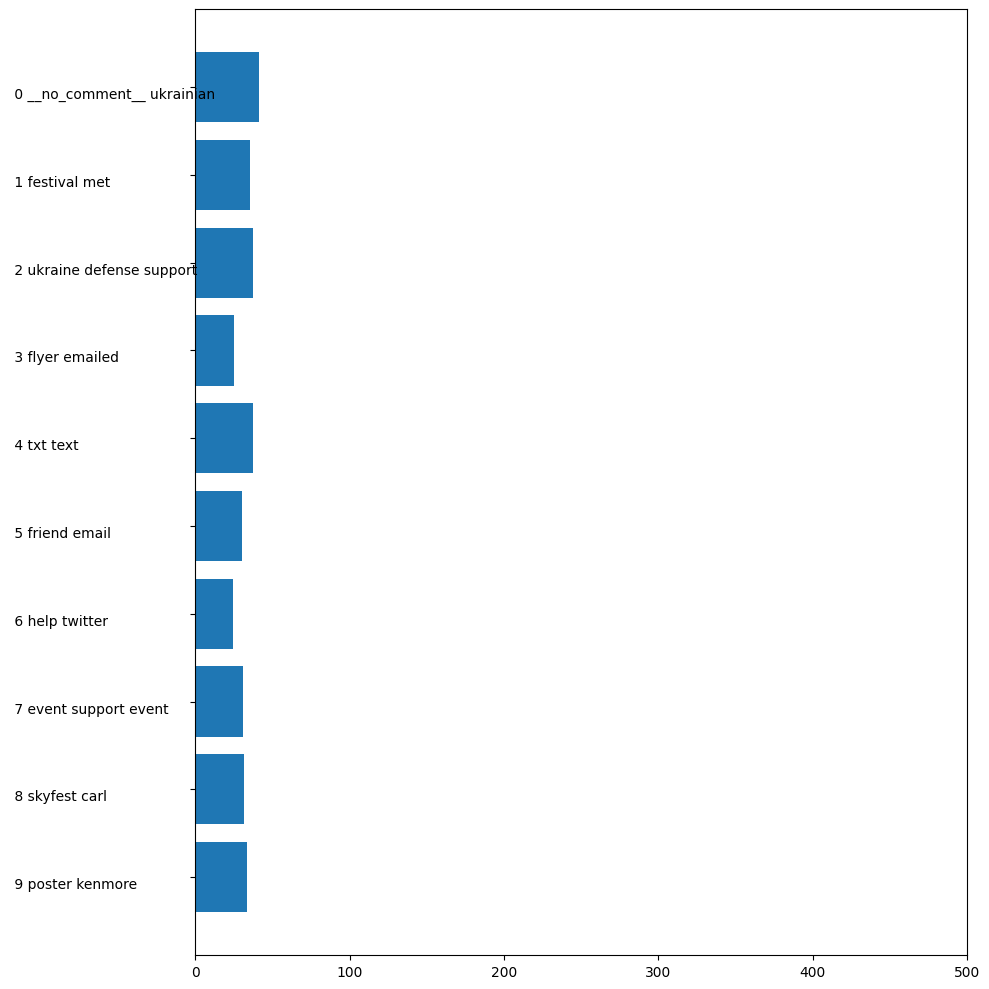

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))

col = 0
start = col * n_topics_c1
end = (col + 1) * n_topics_c1
ax.barh(np.arange(n_topics_c1), np.sum(document_topics_c1, axis=0)[start:end])
ax.set_yticks(np.arange(n_topics_c1))
ax.set_yticklabels(topic_names_c1[start:end], ha="left", va="top")
ax.invert_yaxis()
ax.set_xlim(0, 500)
yax = ax.get_yaxis()
yax.set_tick_params(pad=130)
plt.tight_layout()

##### Visualize Candidate1 with WordCloud

In [35]:
# Join tokens together.
#long_string = ','.join(list(text_train))
long_string = ','.join(vect_c1.vocabulary_)
len(long_string)

2110

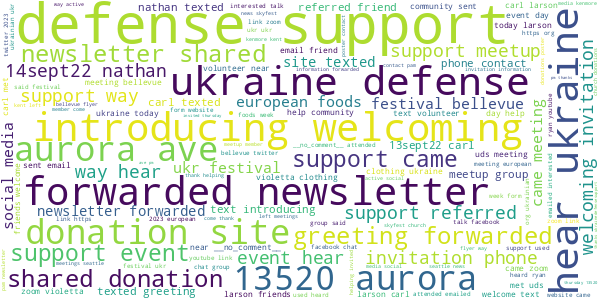

In [36]:
# Create a WordCloud object
wordcloud = WordCloud(stopwords = my_stop_words, background_color="white", max_words=5000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### 4.2 Candidate 2 [extreme example] - Reduce # of topics and ngrams (2,3) 

In [37]:
#tokenize train data and build the vocabulary
vect_c2 = TfidfVectorizer(min_df = .001, ngram_range=(2, 3), stop_words="english")

#`transform` converts text to a bow representation: SciPy sparse matrix only stores non-zero entries
X_c2 = vect_c2.fit_transform(text_train)


In [38]:
# vocab with attribute vocabulary_ <class 'dict'>
print("Vocab size: {}".format(len(vect_c2.vocabulary_)))
#print("Vocab (with word indices): {}".format(vect__c2.vocabulary_))

# get the feature names from the vectorizer
#feature_names_c2 = vect_c2.get_feature_names() #ordered alphabetically
feature_names_c2 = np.array(vect_c2.get_feature_names_out())
print("Number of features: {}".format(len(feature_names_c2)))
print("First 20 features:\n{}".format(feature_names_c2[:20]))

Vocab size: 2867
Number of features: 2867
First 20 features:
['10 boxes' '10 boxes uniforms' '100 just' '100 just contact' '12345 sent'
 '12345 sent new' '12345 tap' '12345 tap mobile' '12532050468 9166147838'
 '12532050468 9166147838 12345' '13 2023' '13 2023 meeting' '13 yesterday'
 '13 yesterday uds' '13520 aurora' '13520 aurora ave' '13sept22 carl'
 '13sept22 carl texted' '14 text' '14 text response']


In [39]:
#save vocab c1 
csv_columns = ['word','idx']
csv_file = "myExplore/vocab_base_index_tfidif_min001.csv"
try:
    with open(csv_file, 'w') as f:
        for key in vect_c2.vocabulary_.keys():
            f.write("%s,%s\n"%(key,vect_c2.vocabulary_[key]))
except IOError:
    print("I/O error")


I/O error


In [40]:
# find maximum value for each of the features over dataset:
max_value = X_c2.max(axis=0).toarray().ravel()
print("Max value shape:", max_value.shape)

sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(feature_names_c2[sorted_by_tfidf[:9]]))

print("Features with highest tfidf: \n{}".format(feature_names_c2[sorted_by_tfidf[-9:]]))

sorted_by_idf = np.argsort(vect_c2.idf_)
print("Features with lowest idf:\n{}".format(feature_names_c2[sorted_by_idf[:20]]))

Max value shape: (2867,)
Features with lowest tfidf:
['email steve thank' 'denton humanitarian'
 'denton humanitarian assistance' 'denton program'
 'denton program transcomm' 'figure free' 'figure free path'
 'following email' 'following email steve']
Features with highest tfidf: 
['european foods' 'evan anderson' 'janet way' 'community event'
 'connected volunteer' 'amanda bremser' 'dad told' 'iiranian demo'
 'sent email']
Features with lowest idf:
['defense support' 'ukraine defense' 'ukraine defense support' 'did hear'
 'hear ukraine' 'hear ukraine defense' 'did hear ukraine'
 'defense support referred' 'support referred' 'support referred friend'
 'defense support event' 'support event' 'referred friend'
 'european foods' 'carl larson' 'festival bellevue' 'support way'
 'support way did' 'way did' 'defense support way']


##### Model Less Topics

In [41]:
n_topics_c2 = 3

lda_c2 = LatentDirichletAllocation(n_components=n_topics_c2, learning_method="batch", max_iter=25, random_state=0)
# Build the model and transform the data in one step
# Computing transform takes some time and we can save time by doing both at once
document_topics_c2 = lda_c2.fit_transform(X_c2)

print("lda_c2.components_.shape: {}".format(lda_c2.components_.shape))

lda_c2.components_.shape: (3, 2867)


In [42]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting_c2 = np.argsort(lda_c2.components_, axis=1)[:, ::-1]


In [43]:
# Print out the n topics:
print_topics(topics=range(n_topics_c2), feature_names=feature_names_c2, sorting=sorting_c2, topics_per_chunk=3, n_words=10)

topic 0                  topic 1                  topic 2                  
--------                 --------                 --------                 
13sept22 carl            defense support          reply email              
13sept22 carl texted     ukraine defense support  carl larson              
carl texted              ukraine defense          community event          
social media             did hear ukraine         alex gamoto              
nathan texted            hear ukraine             met bumper               
14sept22 nathan texted   hear ukraine defense     renton event             
14sept22 nathan          did hear                 staff estraunt           
welcoming invitation phonesupport event            meet rally               
welcoming invitation     defense support event    alan hall                
invitation phone         referred friend          dw com                   




Topics may be specific or not specific enough, many are hard to interpret.  

Examine one topic.  
Confirm the intuition gained from looking at the highest-ranking words per topic by looking at the documents that are assigned to this topic. 

What kinds of comments are assigned to this topic? 

In [44]:
# sort by weight of "music" topic 45
topic_c2  = np.argsort(document_topics_c2[:, 1])[::-1]
print(topic_c2.shape)

# print the five documents where the topic is most important
for i in topic_c2[:10]:
    print("-- ")
    print(text_train.iloc[i][:20])
    # show first two sentences
    #print("--first 2 sentences: ")
    #print(".".join(text_train.iloc[i].split(".")) + ".\n")

(326,)
-- 
I texted her this me
-- 
I reached out to Svi
-- 
Slava was at anniver
-- 
Phone call.  Both Da
-- 
I contacted Ariel in
-- 
Khrystyna came to ou
-- 
emailed when she off
-- 
Roger and wife Franc
-- 
I initially contacte
-- 
How did you hear abo


Another way to inspect topics is to see how much weight each topic gets overall (by summing the document_topics over all reviews).  We name each topic by the two most common tokens.

In [45]:
topic_names_c2 = ["{:>3} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names_c2[sorting_c2[:, :3]])]

topic_names_c2

['  0 13sept22 carl 13sept22 carl texted carl texted',
 '  1 defense support ukraine defense support ukraine defense',
 '  2 reply email carl larson community event']

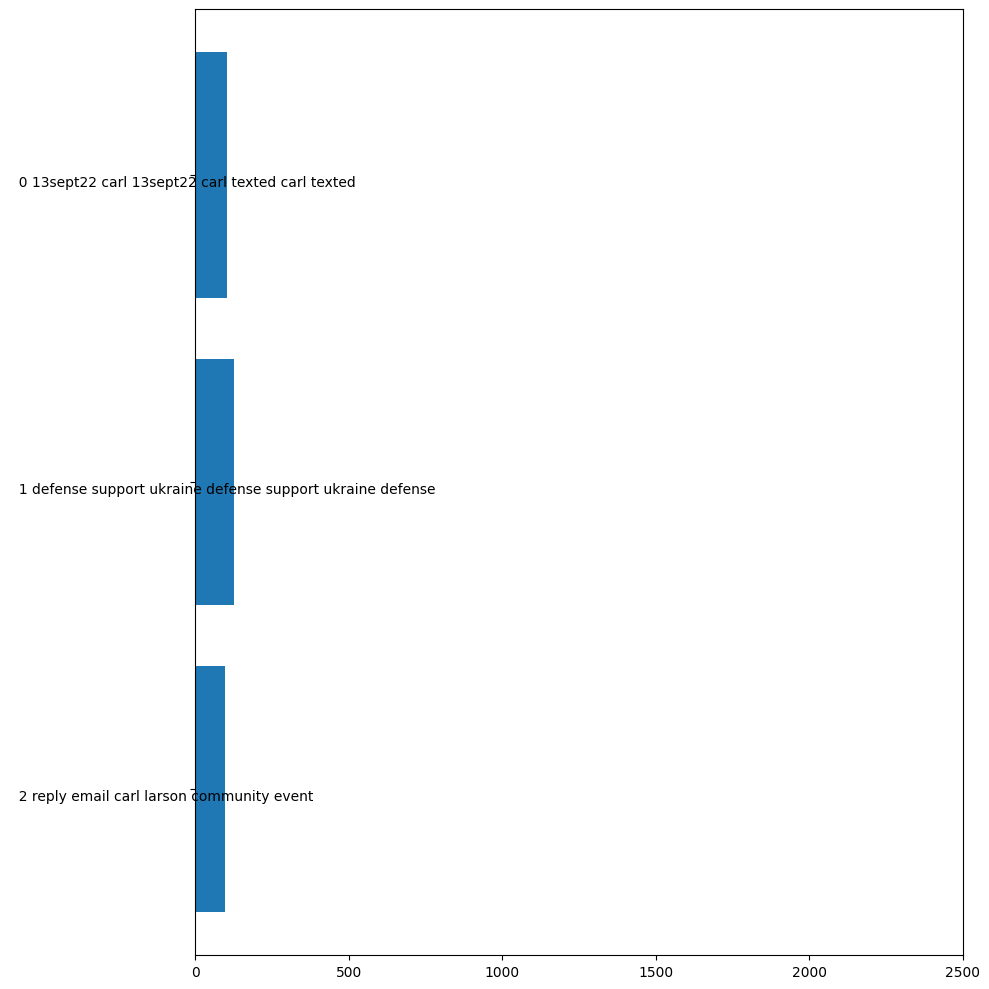

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

col = 0
start = col * n_topics_c2
end = (col + 1) * n_topics_c2
ax.barh(np.arange(n_topics_c2), np.sum(document_topics_c2, axis=0)[start:end])
ax.set_yticks(np.arange(n_topics_c2))
ax.set_yticklabels(topic_names_c2[start:end], ha="left", va="top")
ax.invert_yaxis()
ax.set_xlim(0, 2500)
yax = ax.get_yaxis()
yax.set_tick_params(pad=130)
plt.tight_layout()

##### Visualize Candidate2 with WordCloud

In [47]:
# Join tokens together.
#long_string = ','.join(list(text_train))
long_string = ','.join(vect_c2.vocabulary_)
len(long_string)

51258

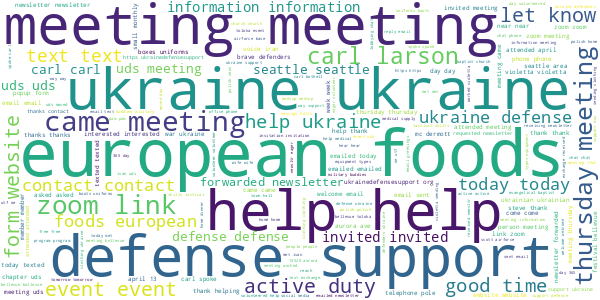

In [48]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, include_numbers=True, collocation_threshold=5, width=600, height=300, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## 4. Limitations of Bag-of-Words and subsequent modeling with LDA
- Semantic meaning, i.e better pay and higher salaries means the same thing but not captured by BOW  
- Haven't done lemmatization: i.e. be and was is the same verb  
- Bi-grams and tri-grams are more comprehensible to humans but skipping uni-grams is not usually recommended
- Recommend to manually fine-tune stopwords? Would need input
- Recommend to replace a few terms, i.e. replace Expeditors with company so can move data to cloud

## 5. Visualize LDA
using pyLDAvis package - Python library for interactive topic model visualization

In [49]:
##from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis.lda_model
import pyLDAvis # for interactive topic model visualization


In [50]:
LDAvis_data_filepath = os.path.join('myVis/ldavis_prepared_'+str(n_topics_c1))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    #LDAvis_prepared = sklearn_lda.prepare(lda_c1, X_c1, vect_c1)
    LDAvis_prepared = pyLDAvis.lda_model.prepare(lda_c1, X_c1, vect_c1)

    with open(LDAvis_data_filepath, 'wb') as f:
            dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = load(f)
    pyLDAvis.save_html(LDAvis_prepared, 'myVis/ldavis_prepared_'+ str(n_topics_c1) +'.html')
    

In [51]:
LDAvis_data_filepath = os.path.join('myVis/ldavis_prepared_'+str(n_topics_c2))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.lda_model.prepare(lda_c2, X_c2, vect_c2)
    with open(LDAvis_data_filepath, 'wb') as f:
            dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = load(f)
    pyLDAvis.save_html(LDAvis_prepared, 'myVis/ldavis_prepared_'+ str(n_topics_c2) +'.html')
    

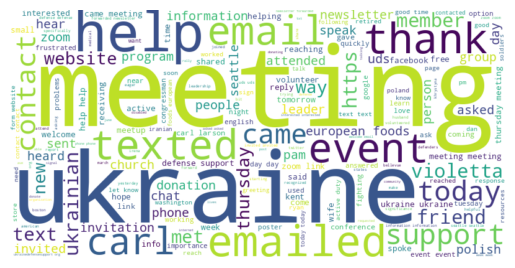

In [52]:
#$xtra
#stop_words = ["https", "co", "RT"] + list(STOPWORDS)
#$learn https://stackoverflow.com/questions/53997443/how-to-add-extra-stop-words-in-addition-to-default-stopwords-in-wordcloud
wordcloud = WordCloud(background_color="white", width=800, height=400,).generate(long_string) #stopwords = stop_words, 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 3. Vis 2D

In [53]:
X_c1.toarray().sum()

610.9128524968828

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

ds = X_c1.toarray()
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto').fit(ds)

kmeans_labels = kmeans.labels_

kmeans_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [55]:
PCA_model = PCA(n_components=2)
y_hat = PCA_model.fit_transform(ds)
print(y_hat.shape)


(326, 2)


In [56]:
x = y_hat[:,0]
y = y_hat[:,1]
labels = df_tidy['Contact rpt. description'].str[:30]

Text(0.5, 1.0, '2D: How did you hear...')

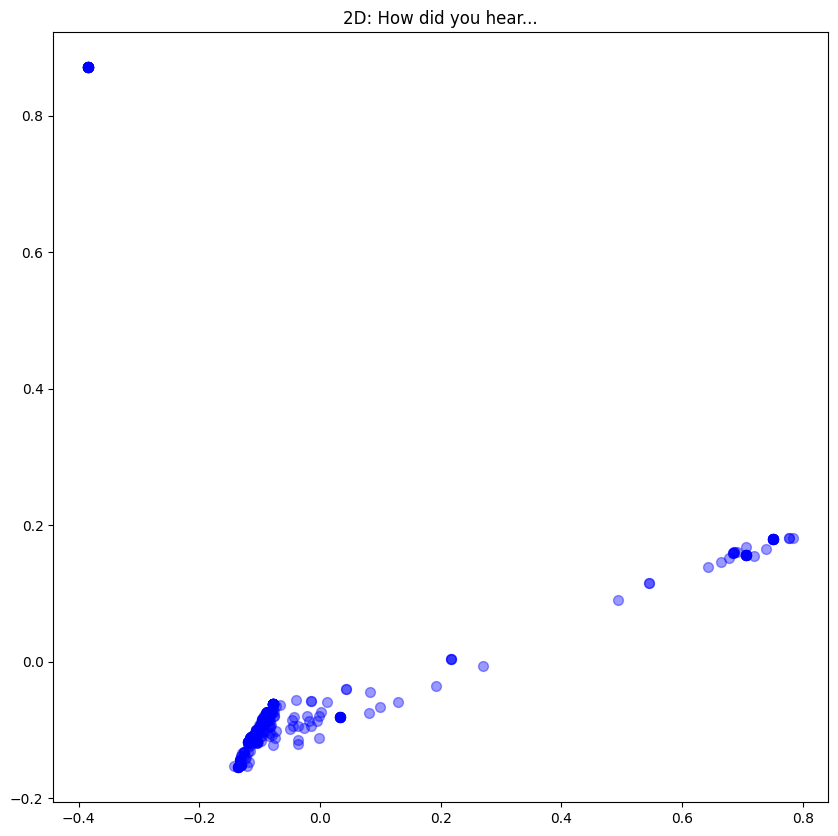

In [57]:
plt.figure(figsize=(10,10))
plt.scatter(x,y, color = 'blue', alpha=0.4, s=50)
plt.title('2D: How did you hear...')

In [58]:
kmeans_labels #class numpy.ndarray
df_tidy['cluster'] = kmeans_labels

#set cluster colors
dict_c = {0:'b', 1:'g', 2:'r'}
df_tidy['color'] = df_tidy['cluster'].map(dict_c)

#preview 
df_tidy.head();

Text(0.5, 1.0, '2D: How did you hear...')

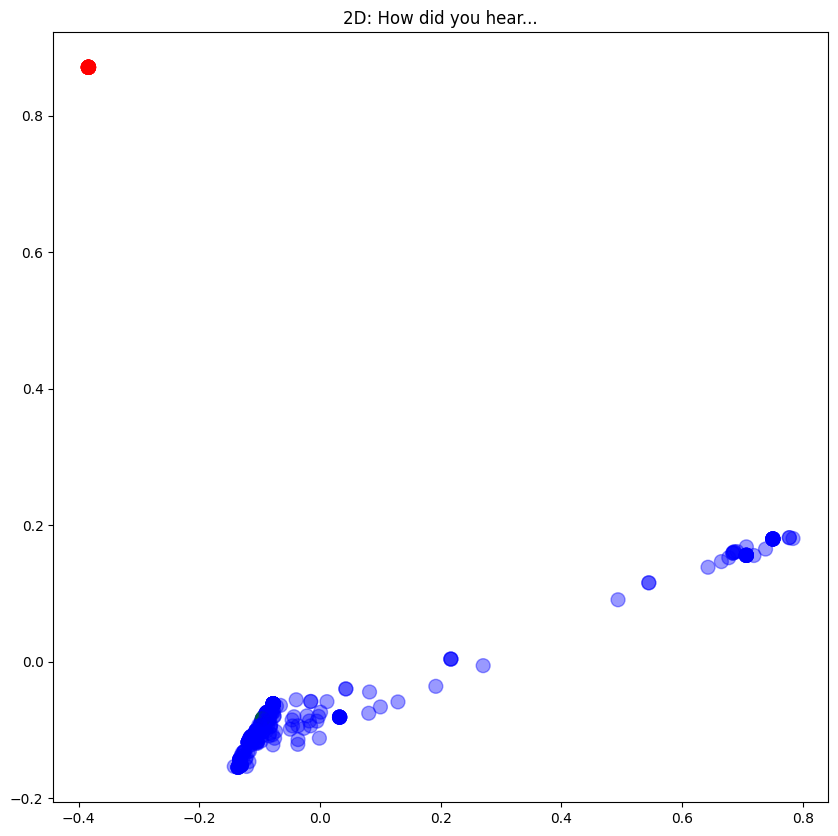

In [59]:
plt.figure(figsize=(10,10))

plt.scatter(x,y, color = df_tidy['color'], alpha=0.4, s=100, edgecolors=df_tidy['color'])
plt.title('2D: How did you hear...')

) missing from current font.yGitrepo/my-razom/.venv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.yGitrepo/my-razom/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


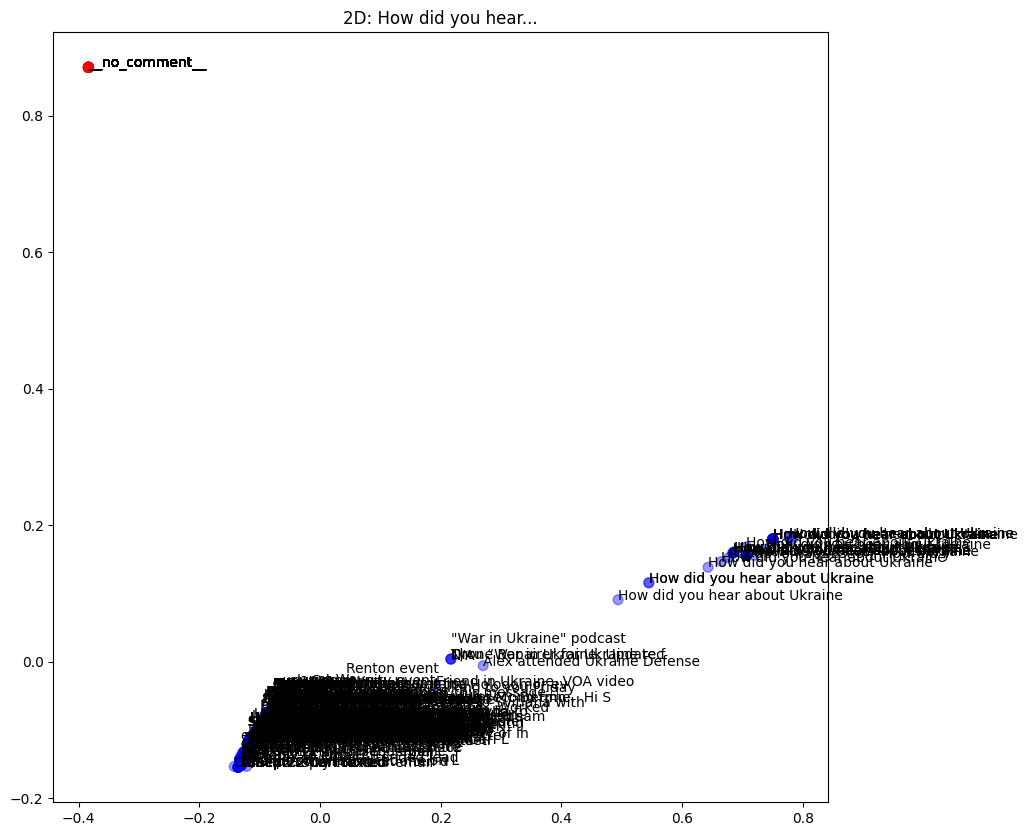

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x,y, color = df_tidy['color'], alpha=0.4, s=50)
plt.title('2D: How did you hear...');

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

## Vis 3D

In [61]:
PCA_model = PCA(n_components=3)
y_hat = PCA_model.fit_transform(ds)
print(y_hat.shape)

(326, 3)


In [62]:
x = y_hat[:,0]
y = y_hat[:,1]
z = y_hat[:,2]

In [63]:
df_tidy3d = df_tidy.copy()
df_tidy3d['x'] = x
df_tidy3d['y'] = y
df_tidy3d['z'] = z
df_tidy3d['label'] = df_tidy3d['all_text'].str[:30]

df_tidy3d.head();


In [64]:
fig = px.scatter_3d(df_tidy3d, x='x',y='y',z='z', opacity = .5, color='color', title= "3D: How did u hear ...", hover_data = 'label', width=600, height=600)
fig.show()

In [65]:

fig = px.scatter_3d(y_hat, x=x,y=y,z=z, opacity = .5, color=df_tidy['color'], title= "3D: How did u hear ...", text = labels, width=600, height=600)
fig.show()

In [66]:
fig.write_html("myVis/3D_vis.html")